In [9]:
import os, itertools
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from joblib import Parallel, delayed
from IPython import embed as shell
import h5py #打开".hdf"文件

from tools_mcginley import utils #jwdegee实验室的package
import analyses_tools #jwdegee自己写的package

In [10]:
cur_dir = os.getcwd() #返回当前工作目录
print('The current working directory is', cur_dir)

The current working directory is /home/jovyan/hddm


In [11]:
matplotlib.rcParams['pdf.fonttype'] = 42 #resource configurations params：mlp画图结果各属性参数
matplotlib.rcParams['ps.fonttype'] = 42 # 避免Type3字体，使用Truetype字体
sns.set(style='ticks', font='Arial', font_scale=1, rc={ # 字典形式设置绘图属性 syle：“ticks”坐标轴带刻度白色背景，font：字体，font_scale:字体大小放缩尺度，rc：sns画图结果各属性
    'axes.labelsize': 7, #坐标轴标签大小
    'axes.titlesize': 7, #坐标轴标题大小
    'xtick.labelsize': 6, #X坐标轴刻度标签大小
    'ytick.labelsize': 6, #Y坐标轴刻度标签大小
    'legend.fontsize': 6, #图例字体大小
    'axes.linewidth': 0.25, #坐标轴线条宽度
    'xtick.major.width': 0.25, #X轴最大刻度宽度
    'ytick.major.width': 0.25, #Y轴最大刻度宽度
    'ytick.minor.width': 0.25,#X轴最小刻度宽度
    'ytick.minor.width': 0.25,#Y轴最小刻度宽度
    'ytick.major.pad' : 2.0,#Y轴最大刻度长度
    'ytick.minor.pad' : 2.0,#Y轴最小刻度长度
    'xtick.major.pad' : 2.0,#X轴最大刻度长度
    'xtick.minor.pad' : 2.0,#X轴最小刻度长度
    'axes.labelpad' : 4.0,#坐标轴标签与坐标轴的距离
    'axes.titlepad' : 6.0,#坐标轴标题与坐标轴的距离
    } )
sns.plotting_context()# 显示出当前状态的数据

{'font.size': 12.0,
 'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'xtick.labelsize': 6.0,
 'ytick.labelsize': 6.0,
 'legend.fontsize': 6.0,
 'axes.linewidth': 0.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 0.25,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

In [12]:
def plot_hazard(): #定义hazard函数
    
    # hazard rate:
    p = np.array([0, 0.228, 0.204, 0.18, 0.157, 0.133, 0.109]) #mini block 中信号出现在2-7个位置的概率组成的数组，trial N=2-7
    h = p.copy() #将p复制一遍
    
    for i in range(len(p)): #计算各位置的hazard rate， i=0为第一次，i=1为第二次，以此类推
        h[i] = h[i] / sum(h[i:]) #在第i次的trial未出现signal的情况下，signal在第i+1次trial出现的概率
    
    x = np.arange(len(h)) #len(h)=7,np.arange(7):生成数组[0,1,2,3,4,5,6]
    
    fig = plt.figure(figsize=(3,1.5)) #plt.figure():创建图像;figuresize:图像大小 宽*高
    
    ax = fig.add_subplot(121) #将figure拆分成子图， 121：共1行2列，处于第1个位置
    plt.scatter(x+1,p) #绘制散点图，横坐标为x，纵坐标为p
    plt.plot(x+1,p) #绘制折线图，横坐标为x，纵坐标为p
    plt.xlabel('Trial in mini block') #X轴标题
    plt.ylabel('P(signal)')    #Y轴标题
    plt.xticks([1,3,5,7]) #X轴刻度
    plt.yticks([0.0,0.1,0.2]) #Y轴刻度
    
    ax = fig.add_subplot(122)#将figure拆分成子图， 122：共1行2列，处于第2个位置
    plt.scatter(x+1,h) #绘制散点图，横坐标为x，纵坐标为h
    plt.plot(x+1,h) #绘制折线图，横坐标为x，纵坐标为h
    plt.xlabel('Trial in mini block')#X轴标题
    plt.ylabel('Hazard rate')#Y轴标题
    plt.xticks([1,3,5,7]) #X轴刻度
    plt.yticks(np.arange(0.0,1.2,0.2)) #Y轴刻度
    
    sns.despine(offset=3, trim=True) #despine()：删除图像上部和右侧的坐标轴，offset=？:两轴偏离的距离，trim：为True时，将坐标轴限制在数据最大/最小值
    plt.tight_layout() #自动调整子图参数，使之填充整个图像区域
    
    return fig

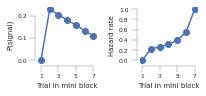

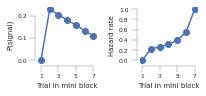

In [13]:
plot_hazard() #jn中图出现两次是因为函数执行过程中出现一次，return返回一次

In [14]:
def plot_pupil_hazard(df):
    df['last_interval'] = df['interval'] #将数据中"interval"列的数据赋值到"last_interval"
    
    acc = np.array(df.loc[df['stimulus']==1,:].groupby(['subject', 'last_interval']).mean().groupby('last_interval').mean()['correct'])
    #df:数据，loc[df['stimulus']==1,:]：选取数据中列"stimulus"==1的行+所有列，
    #groupby(['subject', 'last_interval'])以"subject""last_interval"为条件进行分组，mean()求平均值后
    # groupby('last_interval')：再以"last_interval"为分组条件，mean（）：再求平均值，["correct"]：从中选取“correct”列
    
    acc_sem = np.array(df.loc[df['stimulus']==1,['subject', 'last_interval', 'correct']].groupby(['subject', 'last_interval']).mean().groupby('last_interval').sem())
    #df:数据，loc[df['stimulus']==1,['subject', 'last_interval', 'correct']]：选取数据中列"stimulus"==1的行+'subject', 'last_interval', 'correct'列
    #groupby(['subject', 'last_interval'])以"subject""last_interval"为条件进行分组，mean()求平均值后
    # groupby('last_interval')：再以"last_interval"为分组条件，sem()：求平均数标准误
    
    pupil = np.array(df.groupby(['subject', 'last_interval']).mean().groupby('last_interval').mean()['pupil_stim_1s'])
    #df:数据
    #groupby(['subject', 'last_interval'])以"subject""last_interval"为条件进行分组，mean()求平均值后
    # groupby('last_interval')：再以"last_interval"为分组条件，mean（）：再求平均值，["pupil_stim_1s"]：从中选取“pupil_stim_1s”列
    
    pupil_sem = np.array(df.loc[:,['subject', 'last_interval', 'pupil_stim_1s']].groupby(['subject', 'last_interval']).mean().groupby('last_interval').sem())
    #df:数据，loc[:,['subject', 'last_interval', 'pupil_stim_1s']：选取数据中所有的行+'subject', 'last_interval', 'pupil_stim_1s'列
    #groupby(['subject', 'last_interval'])以"subject""last_interval"为条件进行分组，mean()求平均值后
    # groupby('last_interval')：再以"last_interval"为分组条件，sem()：求平均数标准误
    
    aovrm = AnovaRM(df.groupby(['subj_idx', 'interval']).mean().reset_index(), 'pupil_stim_1s', 'subj_idx', within=['interval'], aggregate_func='mean')
    #df.groupby(['subj_idx', 'interval']).mean()：以'subj_idx', 'interval'为分组条件求平均值，reset_index()：重置索引
    #'pupil_stim_1s'：因变量, 'subj_idx'：主题标识, within=['interval']：自变量, aggregate_func='mean'：观察值
    res = aovrm.fit()
    #模型拟合
    print(res)

    x = np.arange(2,8)
    #生成数组[2, 3, 4, 5, 6, 7]

    fig = plt.figure(figsize=(3,1.5))#plt.figure():创建图像;figuresize:图像大小 宽*高
    
    ax = fig.add_subplot(121) #将figure拆分成子图， 121：共1行2列，处于第1个位置
    plt.errorbar(x, acc, yerr=acc_sem)#绘制带误差线的折线图，x轴取值为x，y轴取值为acc，y的误差为acc_sem
    plt.xlabel('Trial in mini block')#X轴标签
    plt.ylabel('Accuracy')#Y轴标签
    
    ax = fig.add_subplot(122)#将figure拆分成子图， 121：共1行2列，处于第2个位置
    plt.errorbar(x, pupil, yerr=pupil_sem)#绘制带误差线的折线图，x轴取值为x，y轴取值为pupil，y的误差为pupil_sem
    plt.xlabel('Trial in mini block')#X轴标签
    plt.ylabel('Pupil response')#Y轴标签
    plt.ylim(4,8.5)#Y轴范围
    
    sns.despine(offset=3, trim=True)#despine()：删除图像上部和右侧的坐标轴，offset=？:两轴偏离的距离，trim：为True时，将坐标轴限制在数据最大/最小值
    
    plt.tight_layout()#自动调整子图参数，使之填充整个图像区域
    
    return fig

In [15]:
plot_pupil_hazard(df)

NameError: name 'df' is not defined

In [16]:
def baseline_correlation(df): #基线相关

    fig = plt.figure(figsize=(1.5*10, 1.5*6))
    #plt.figure():创建图像;figuresize:图像大小 宽*高
    
    plt_nr = 1
    
    rs = np.zeros(len(df['subject'].unique()))
    ps = np.zeros(len(df['subject'].unique()))
    #df['subject'].unique()：不重复的subject的值
    #np.zeros(len()):创建长度为len()的值为0的数组
    
    for s, d in df.groupby(['subj_idx']):#共len(df['subject'].unique()）个循环，s,d =  df.groupby(['subj_idx'])
        ax = fig.add_subplot(6,10,plt_nr) #   #将figure拆分成子图，6列，10行  ，第plt_nr个
        
        sns.regplot(x='pupil_0', y='pupil_resp_1s', scatter=True, fit_reg=True, data=d, ax=ax, scatter_kws={'alpha':0.1, 's':2, 'rasterized':True})
        #sns.regplot()：绘图数据和线性回归模型拟合，x:x轴数据 ，y：y轴数据, scatter:散点图 ，fit_reg:回归拟合， data:数据来源
        #ax:绘图位置 scatter_kws:字典形式，设置散点细节 可以输入任何plt.scatter支持的参数 alpha：透明度 s：size 大小 rasterized
        
        
        #plt.xlim(df['pupil_0'].quantile(0.05), df['pupil_0'].quantile(0.95))
        #plt.ylim(df['pupil_resp_1s'].quantile(0.05), df['pupil_resp_1s'].quantile(0.95))
        
        r,p = sp.stats.pearsonr(d['pupil_0'], d['pupil_resp_1s'])#计算皮尔逊相关系数 r相关系数 p显著性
        rs[plt_nr-1] = r #将r,p 的值赋给rs，ps ，因为plt_nr从1开始，rs ps从0开始 因此-1，
        ps[plt_nr-1] = p
        plt.title('r = {}, p = {}'.format(round(np.mean(r),3), round(p, 3))) #‘’.format() 传入值， round（ ，3）：数值保留3位小数 np.mean(#数组)求平均值
        plt_nr += 1 #为下一次循环赋值
    
    ax = fig.add_subplot(6,10,plt_nr) #将figure拆分成子图，6列，10行  ，第plt_nr个，即最后一幅图
    sns.swarmplot(x=None, y=rs[ps<=0.05], color='g') #分簇散点图， x轴无 ，y轴为rs中ps<=0.05的列，颜色为green
    sns.swarmplot(x=None, y=rs[ps>0.05])#分簇散点图， x轴无 ，y轴为rs中ps>0.05的列，颜色为默认
    sns.despine(offset=3, trim=True)#despine()：删除图像上部和右侧的坐标轴，offset=？:两轴偏离的距离，trim：为True时，将坐标轴限制在数据最大/最小值
    plt.tight_layout()#自动调整子图参数，使之填充整个图像区域

    fig2 = plt.figure(figsize=(2,2)) #plt.figure():创建图像;figuresize:图像大小 宽*高
    ax = fig2.add_subplot(111)   #将figure拆分成子图，1列，1行  ，第1个
    sns.regplot(x='pupil_0', y='pupil_resp_1s', scatter=True, fit_reg=False, x_bins=20, data=df, ax=ax)
    #sns.regplot()：绘图数据和线性回归模型拟合，x:x轴数据 ，y：y轴数据, scatter:散点图 ，fit_reg:回归拟合， data:数据来源
    #ax:绘图位置 x_bins:将x分为多少段 units：采样单元，同时考虑观测值和采样单元来计算多层次的置信区间，而不影响回归和均值
        
        
    return fig

In [17]:
baseline_correlation(df)

NameError: name 'df' is not defined

In [18]:
# variables:
project_dir = '/home/jovyan/hddm' #项目的目录

exp_names = [ #数据名称
    'gonogo_audio_mouse',
    'gonogo_audio_human',
    'yesno_audio',
    'bias_manipulation_30', 
    'bias_manipulation_70',
    'image_recognition',
    ]

rt_cutoffs = [ #剪除的反应时
    (0.28, 1.5),
    (0.55, 1.0),
    (0.55, 2.5),
    (0.55, 2.5), 
    (0.55, 2.5),
    (0.55, 7.5),
    ]

pupil_cutoffs = [ #剪除的瞳孔数据
    [(0.04,0.23), (0.04,0.23),],
    [(0.23,0.50), (0.23,0.50),],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    [(0.23,0.5), (-0.55, -0.05)],
    ]

nrs_bins = [ #将被试数据分的段数
    5,
    5,
    5,
    3,
    3,
    2,
    ]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Using a threshold of 2.045230
stat_fun(H1): min=-6.749133 max=8.715489
Running initial clustering
Found 3 clusters
Permuting 4999 times...



Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-6.749133 max=8.715489
Running initial clustering
Found 3 clusters
Permuting 4999 times...



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value  
No. Observations:     25        Method:               REML   
No. Groups:           5         Scale:                0.0006 
Min. group size:      5         Log-Likelihood:       43.5540
Max. group size:      5         Converged:            No     
Mean group size:      5.0                                    
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
intercept           0.632    0.010 63.031 0.000  0.612  0.652
bin                 0.000    0.007  0.067 0.947 -0.013  0.013
intercept Var       0.000    0.008                           
intercept x bin Cov 0.000    0.006                           
bin Var             0.000    0.008                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value 
No. Observations:     25         Method:                REML  
No. Groups:           5          Scale:                 0.0225
Min. group size:      5          Log-Likelihood:        1.7823
Max. group size:      5          Converged:             Yes   
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.559    0.094  5.934 0.000  0.374  0.743
bin                 -0.000    0.030 -0.005 0.996 -0.058  0.058
intercept Var        0.031    0.235                           
intercept x bin Cov -0.001    0.051                           
bin Var              0.002    0.023                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 25      Method:             REML   
No. Groups:       5       Scale:              0.0079 
Min. group size:  5       Log-Likelihood:     14.0824
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   0.870    0.074 11.835 0.000  0.726  1.014
bin         0.020    0.013  1.620 0.105 -0.004  0.045
Group Var   0.022    0.210                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 25      Method:             REML   
No. Groups:       5       Scale:              0.0079 
Min. group size:  5       Log-Likelihood:     14.0824
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   0.870    0.074 11.835 0.000  0.726  1.014
bin         0.020    0.013  1.620 0.105 -0.004  0.045
Group Var   0.022    0.210                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value 
No. Observations: 25      Method:             REML  
No. Groups:       5       Scale:              0.0126
Min. group size:  5       Log-Likelihood:     9.7303
Max. group size:  5       Converged:          Yes   
Mean group size:  5.0                               
----------------------------------------------------
            Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------
intercept   0.670    0.074 9.009 0.000  0.524  0.816
bin         0.027    0.016 1.694 0.090 -0.004  0.058
Group Var   0.020    0.157                          



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 30      Method:             REML   
No. Groups:       5       Scale:              0.0046 
Min. group size:  6       Log-Likelihood:     24.7670
Max. group size:  6       Converged:          Yes    
Mean group size:  6.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.154    0.071  16.146 0.000  1.014  1.294
level     -0.097    0.007 -13.388 0.000 -0.111 -0.083
Group Var  0.023    0.269                            



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 30      Method:             REML   
No. Groups:       5       Scale:              0.0046 
Min. group size:  6       Log-Likelihood:     24.7670
Max. group size:  6       Converged:          Yes    
Mean group size:  6.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.154    0.071  16.146 0.000  1.014  1.294
level     -0.097    0.007 -13.388 0.000 -0.111 -0.083
Group Var  0.023    0.269                            



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value 
No. Observations: 30      Method:             REML  
No. Groups:       5       Scale:              0.0184
Min. group size:  6       Log-Likelihood:     7.0086
Max. group size:  6       Converged:          Yes   
Mean group size:  6.0                               
----------------------------------------------------
           Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------
intercept  0.072    0.098  0.733 0.463 -0.121  0.265
level      0.194    0.015 13.388 0.000  0.166  0.223
Group Var  0.039    0.235                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 30      Method:             REML   
No. Groups:       5       Scale:              0.0000 
Min. group size:  6       Log-Likelihood:     93.6761
Max. group size:  6       Converged:          Yes    
Mean group size:  6.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   0.640    0.017 37.389 0.000  0.607  0.674
level      -0.003    0.001 -5.731 0.000 -0.004 -0.002
Group Var   0.001    0.229                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 150     Method:             REML    
No. Groups:       5       Scale:              0.0009  
Min. group size:  30      Log-Likelihood:     294.6094
Max. group size:  30      Converged:          Yes     
Mean group size:  30.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    0.639    0.018 36.026 0.000  0.605  0.674
level       -0.003    0.001 -2.131 0.033 -0.006 -0.000
bin          0.000    0.002  0.261 0.794 -0.003  0.004
Group Var    0.001    0.036                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 150     Method:             REML    
No. Groups:       5       Scale:              0.1072  
Min. group size:  30      Log-Likelihood:     -57.7503
Max. group size:  30      Converged:          Yes     
Mean group size:  30.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    0.073    0.106  0.681 0.496 -0.136  0.281
level        0.194    0.016 12.421 0.000  0.164  0.225
bin         -0.000    0.019 -0.008 0.993 -0.037  0.037
Group Var    0.038    0.092                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 150     Method:             REML   
No. Groups:       5       Scale:              0.0277 
Min. group size:  30      Log-Likelihood:     40.1912
Max. group size:  30      Converged:          Yes    
Mean group size:  30.0                               
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.113    0.074  14.954 0.000  0.967  1.259
level     -0.097    0.008 -12.223 0.000 -0.113 -0.082
bin        0.020    0.010   2.116 0.034  0.001  0.039
Group Var  0.023    0.103                            



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 150     Method:             REML   
No. Groups:       5       Scale:              0.0277 
Min. group size:  30      Log-Likelihood:     40.1912
Max. group size:  30      Converged:          Yes    
Mean group size:  30.0                               
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.113    0.074  14.954 0.000  0.967  1.259
level     -0.097    0.008 -12.223 0.000 -0.113 -0.082
bin        0.020    0.010   2.116 0.034  0.001  0.039
Group Var  0.023    0.103                            



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Using a threshold of 2.093024
stat_fun(H1): min=-5.031340 max=12.959423
Running initial clustering
Found 3 clusters
Permuting 4999 times...



Computing cluster p-values
Done.
Using a threshold of 2.093024
stat_fun(H1): min=-5.031340 max=12.959423
Running initial clustering
Found 3 clusters
Permuting 4999 times...



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 100     Method:             REML    
No. Groups:       20      Scale:              0.0004  
Min. group size:  5       Log-Likelihood:     210.2451
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    0.729    0.008 89.286 0.000  0.713  0.745
bin          0.000    0.001  0.006 0.996 -0.003  0.003
Group Var    0.001    0.020                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value   
No. Observations:     100       Method:               REML    
No. Groups:           20        Scale:                0.0479  
Min. group size:      5         Log-Likelihood:       -18.3324
Max. group size:      5         Converged:            Yes     
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            2.259    0.063 35.846 0.000  2.135  2.382
bin                 -0.014    0.021 -0.664 0.507 -0.054  0.027
intercept Var        0.051    0.135                           
intercept x bin Cov -0.002    0.032                           
bin Var              0.004    0.014                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 100     Method:             REML   
No. Groups:       20      Scale:              0.0143 
Min. group size:  5       Log-Likelihood:     35.5706
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   0.653    0.056 11.662 0.000  0.543  0.762
bin         0.009    0.008  1.050 0.294 -0.008  0.025
Group Var   0.054    0.172                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 100     Method:             REML   
No. Groups:       20      Scale:              0.0143 
Min. group size:  5       Log-Likelihood:     35.5706
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   0.653    0.056 11.662 0.000  0.543  0.762
bin         0.009    0.008  1.050 0.294 -0.008  0.025
Group Var   0.054    0.172                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    100        Method:                REML   
No. Groups:          20         Scale:                 0.0137 
Min. group size:     5          Log-Likelihood:        30.7285
Max. group size:     5          Converged:             No     
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.667    0.063 10.547 0.000  0.543  0.790
bin                  0.007    0.011  0.598 0.550 -0.015  0.028
intercept Var        0.072    0.309                           
intercept x bin Cov -0.003    0.054                           
bin Var              0.001    0.018                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 80      Method:             REML   
No. Groups:       20      Scale:              0.0087 
Min. group size:  4       Log-Likelihood:     38.7370
Max. group size:  4       Converged:          Yes    
Mean group size:  4.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.080    0.055  19.579 0.000  0.972  1.188
level     -0.273    0.009 -29.206 0.000 -0.291 -0.255
Group Var  0.055    0.227                            



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 80      Method:             REML   
No. Groups:       20      Scale:              0.0087 
Min. group size:  4       Log-Likelihood:     38.7370
Max. group size:  4       Converged:          Yes    
Mean group size:  4.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept  1.080    0.055  19.579 0.000  0.972  1.188
level     -0.273    0.009 -29.206 0.000 -0.291 -0.255
Group Var  0.055    0.227                            



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 80      Method:             REML   
No. Groups:       20      Scale:              0.0349 
Min. group size:  4       Log-Likelihood:     -3.4639
Max. group size:  4       Converged:          Yes    
Mean group size:  4.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   1.413    0.064 22.197 0.000  1.288  1.537
level       0.546    0.019 29.206 0.000  0.509  0.582
Group Var   0.057    0.130                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 80      Method:             REML    
No. Groups:       20      Scale:              0.0001  
Min. group size:  4       Log-Likelihood:     197.3052
Max. group size:  4       Converged:          Yes     
Mean group size:  4.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    0.752    0.008 95.440 0.000  0.737  0.768
level       -0.003    0.004 -0.669 0.504 -0.010  0.005
level_^2    -0.005    0.001 -4.417 0.000 -0.008 -0.003
Group Var    0.001    0.040                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    value   
No. Observations:      400        Method:                REML    
No. Groups:            20         Scale:                 0.0007  
Min. group size:       20         Log-Likelihood:        833.8475
Max. group size:       20         Converged:             Yes     
Mean group size:       20.0                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
intercept              0.757    0.009  84.159 0.000  0.740  0.775
level                 -0.019    0.001 -12.773 0.000 -0.022 -0.016
bin                    0.000    0.001   0.008 0.994 -0.002  0.002
intercept Var          0.001    0.021                            
intercept x level Cov -0.000    0.003                            
level Var              0

/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value    
No. Observations: 400     Method:             REML     
No. Groups:       20      Scale:              0.1543   
Min. group size:  20      Log-Likelihood:     -222.1162
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
intercept     1.440    0.069 20.936 0.000  1.305  1.575
level         0.546    0.018 31.071 0.000  0.511  0.580
bin          -0.014    0.014 -0.982 0.326 -0.041  0.014
Group Var     0.058    0.055                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     400         Method:                 REML   
No. Groups:           20          Scale:                  0.0376 
Min. group size:      20          Log-Likelihood:         43.0092
Max. group size:      20          Converged:              Yes    
Mean group size:      20.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
intercept              1.062    0.064  16.671 0.000  0.937  1.187
level                 -0.273    0.010 -27.937 0.000 -0.292 -0.254
bin                    0.009    0.008   1.128 0.259 -0.007  0.024
intercept Var          0.072    0.140                            
intercept x level Cov -0.005    0.020                            
level Var              0

/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     400         Method:                 REML   
No. Groups:           20          Scale:                  0.0376 
Min. group size:      20          Log-Likelihood:         43.0092
Max. group size:      20          Converged:              Yes    
Mean group size:      20.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
intercept              1.062    0.064  16.671 0.000  0.937  1.187
level                 -0.273    0.010 -27.937 0.000 -0.292 -0.254
bin                    0.009    0.008   1.128 0.259 -0.007  0.024
intercept Var          0.072    0.140                            
intercept x level Cov -0.005    0.020                            
level Var              0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Using a threshold of 2.068658
stat_fun(H1): min=-8.330867 max=9.494974
Running initial clustering
Found 4 clusters
Permuting 4999 times...



Computing cluster p-values
Done.
Using a threshold of 2.068658
stat_fun(H1): min=-10.638659 max=16.408527
Running initial clustering
Found 3 clusters
Permuting 4999 times...



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jovyan/hddm/analyses_tools.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(1.1*len(df['variable'].unique()), 1.5))
/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 120     Method:             REML    
No. Groups:       24      Scale:              0.0005  
Min. group size:  5       Log-Likelihood:     195.3880
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    1.255    0.068 18.417 0.000  1.121  1.388
bin         -0.005    0.001 -3.625 0.000 -0.008 -0.002
Group Var    0.111    1.637                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value 
No. Observations:     120        Method:                REML  
No. Groups:           24         Scale:                 0.0315
Min. group size:      5          Log-Likelihood:        1.7649
Max. group size:      5          Converged:             No    
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.391    0.057 24.587 0.000  1.280  1.502
bin                 -0.007    0.013 -0.596 0.551 -0.032  0.017
intercept Var        0.058    0.170                           
intercept x bin Cov  0.001    0.025                           
bin Var              0.001    0.008                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 120     Method:             REML   
No. Groups:       24      Scale:              0.0069 
Min. group size:  5       Log-Likelihood:     76.7882
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
intercept    0.043    0.054 0.807 0.420 -0.062  0.148
bin          0.016    0.005 3.039 0.002  0.006  0.027
Group Var    0.065    0.262                          



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 120     Method:             REML   
No. Groups:       24      Scale:              0.0075 
Min. group size:  5       Log-Likelihood:     82.6974
Max. group size:  5       Converged:          Yes    
Mean group size:  5.0                                
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
intercept    0.199    0.036 5.571 0.000  0.129  0.269
bin          0.004    0.006 0.705 0.481 -0.007  0.015
Group Var    0.026    0.104                          



/home/jovyan/hddm/analyses_tools.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(1.5,1.5))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Using a threshold of 2.144787
stat_fun(H1): min=-6.481724 max=9.947574
Running initial clustering
Found 4 clusters
Permuting 4999 times...


/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.
Using a threshold of 2.144787
stat_fun(H1): min=-5.697433 max=7.697604
Running initial clustering
Found 2 clusters
Permuting 4999 times...


/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jovyan/hddm/analyses_tools.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 45      Method:             REML   
No. Groups:       15      Scale:              0.0004 
Min. group size:  3       Log-Likelihood:     58.2396
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   1.435    0.071 20.178 0.000  1.295  1.574
bin        -0.003    0.004 -0.695 0.487 -0.010  0.005
Group Var   0.075    1.683                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 45      Method:             REML    
No. Groups:       15      Scale:              0.0832  
Min. group size:  3       Log-Likelihood:     -30.7065
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    2.139    0.182 11.785 0.000  1.784  2.495
bin         -0.114    0.053 -2.160 0.031 -0.217 -0.011
Group Var    0.425    0.723                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 45      Method:             REML   
No. Groups:       15      Scale:              0.0225 
Min. group size:  3       Log-Likelihood:     -0.7351
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
intercept    0.401    0.084 4.791 0.000  0.237  0.566
bin          0.031    0.027 1.115 0.265 -0.023  0.084
Group Var    0.087    0.289                          



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 45      Method:             REML   
No. Groups:       15      Scale:              0.0225 
Min. group size:  3       Log-Likelihood:     -0.7351
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
intercept    0.401    0.084 4.791 0.000  0.237  0.566
bin          0.031    0.027 1.115 0.265 -0.023  0.084
Group Var    0.087    0.289                          



/home/jovyan/hddm/analyses_tools.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(1.5,1.5))


Using a threshold of 2.144787
stat_fun(H1): min=-6.458611 max=9.989133
Running initial clustering
Found 2 clusters
Permuting 4999 times...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.
Using a threshold of 2.144787
stat_fun(H1): min=-7.223675 max=6.181337
Running initial clustering
Found 3 clusters
Permuting 4999 times...


/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jovyan/hddm/analyses_tools.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value  
No. Observations: 45      Method:             REML   
No. Groups:       15      Scale:              0.0005 
Min. group size:  3       Log-Likelihood:     58.4742
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
intercept   1.448    0.063 22.987 0.000  1.324  1.571
bin        -0.001    0.004 -0.126 0.899 -0.008  0.007
Group Var   0.059    1.253                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 45      Method:             REML    
No. Groups:       15      Scale:              0.0643  
Min. group size:  3       Log-Likelihood:     -23.7714
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
intercept    2.014    0.146 13.812 0.000  1.728  2.299
bin         -0.032    0.046 -0.698 0.485 -0.123  0.058
Group Var    0.265    0.520                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value 
No. Observations: 45      Method:             REML  
No. Groups:       15      Scale:              0.0162
Min. group size:  3       Log-Likelihood:     3.9133
Max. group size:  3       Converged:          Yes   
Mean group size:  3.0                               
----------------------------------------------------
          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------
intercept -0.398    0.083 -4.793 0.000 -0.561 -0.235
bin       -0.033    0.023 -1.415 0.157 -0.078  0.013
Group Var  0.090    0.345                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value 
No. Observations: 45      Method:             REML  
No. Groups:       15      Scale:              0.0162
Min. group size:  3       Log-Likelihood:     3.9133
Max. group size:  3       Converged:          Yes   
Mean group size:  3.0                               
----------------------------------------------------
            Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------
intercept   0.398    0.083 4.793 0.000  0.235  0.561
bin         0.033    0.023 1.415 0.157 -0.013  0.078
Group Var   0.090    0.345                          



/home/jovyan/hddm/analyses_tools.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(1.5,1.5))
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Using a threshold of 2.007584
stat_fun(H1): min=-9.059648 max=10.212350
Running initial clustering
Found 5 clusters
Permuting 4999 times...


/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.
Using a threshold of 2.007584
stat_fun(H1): min=-6.474806 max=9.679154
Running initial clustering
Found 3 clusters
Permuting 4999 times...


/home/jovyan/hddm/analyses_tools.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,1.5))



Computing cluster p-values
Done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jovyan/hddm/analyses_tools.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

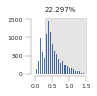

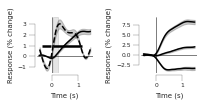

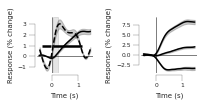

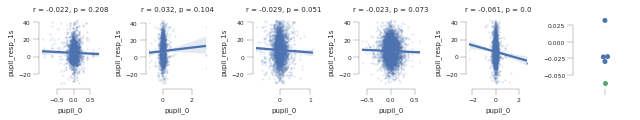

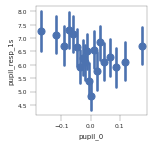

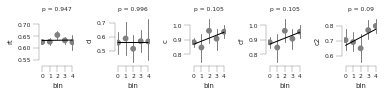

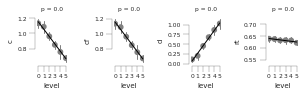

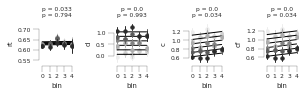

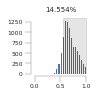

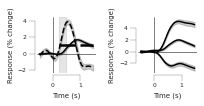

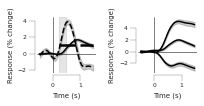

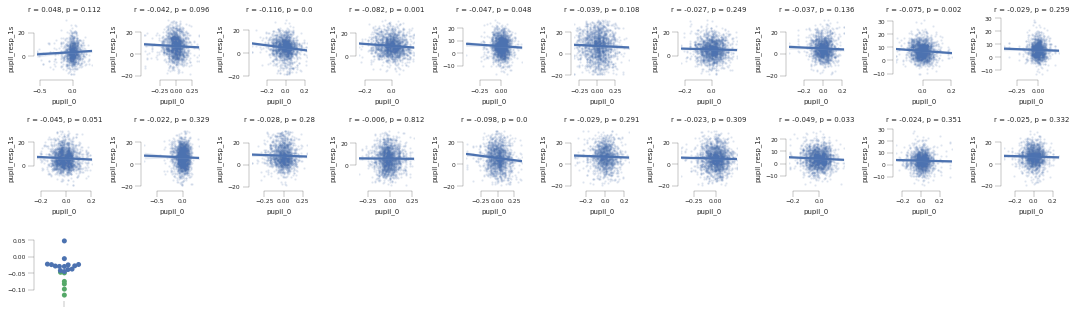

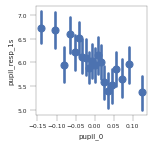

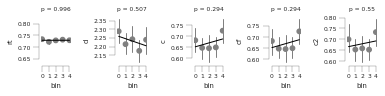

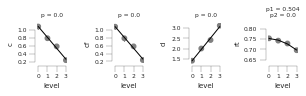

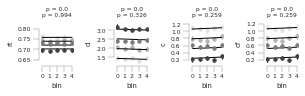

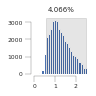

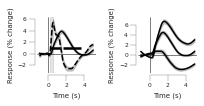

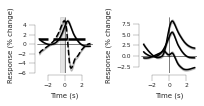

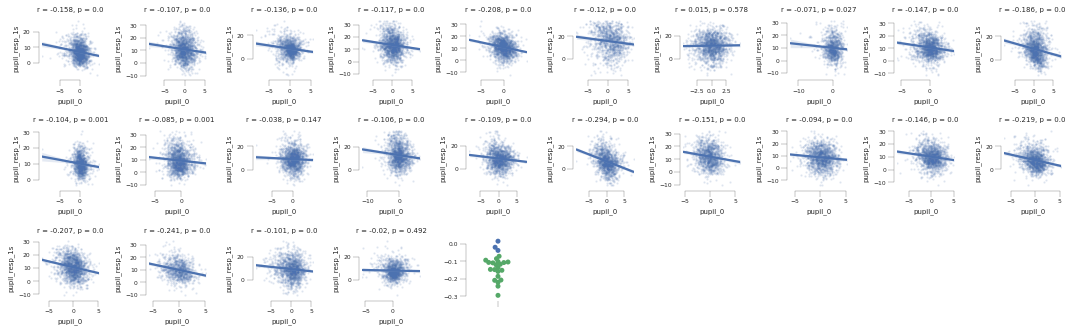

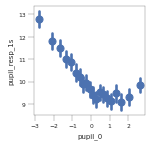

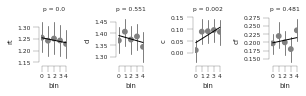

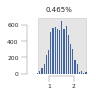

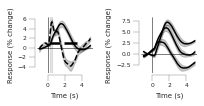

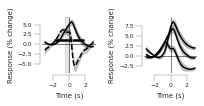

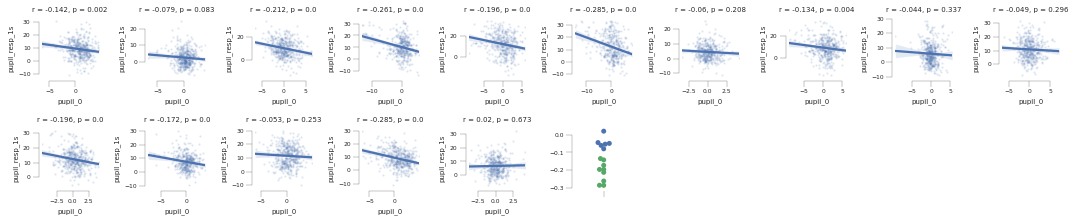

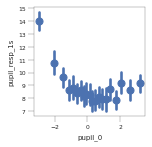

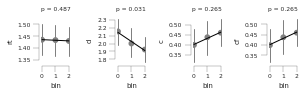

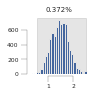

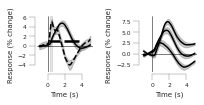

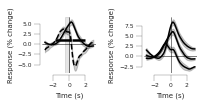

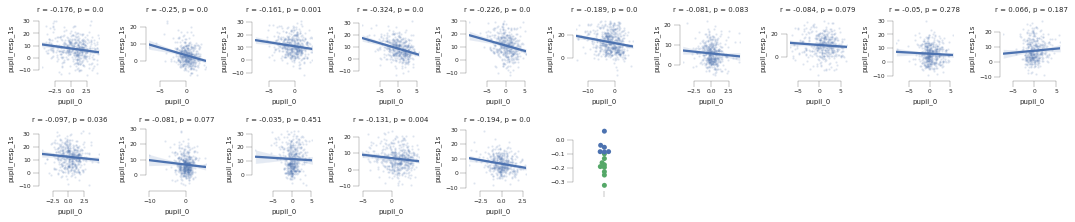

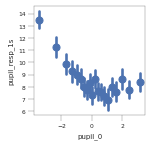

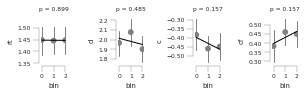

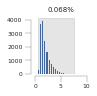

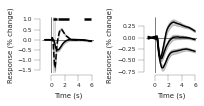

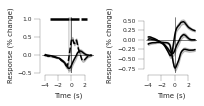

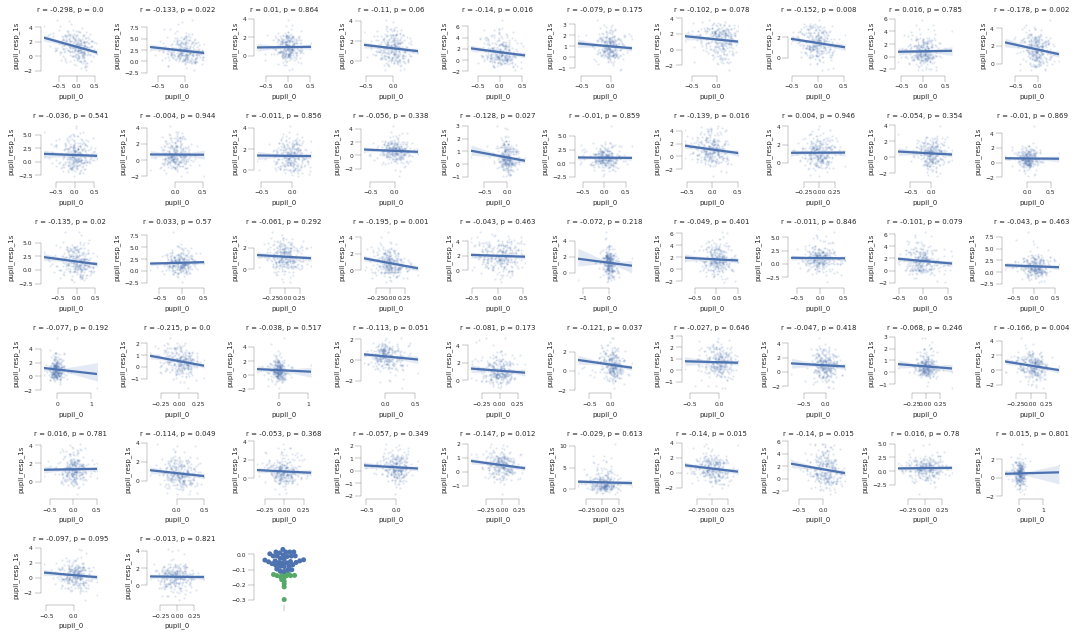

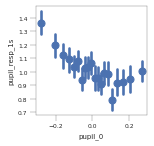

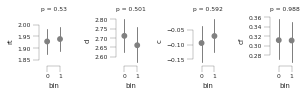

In [19]:
for analyse_exp in [0,1,2,3,4,5]:
#for analyse_exp in [0]: #第一次分析

    exp_name, rt_cutoff, pupil_cutoff, nr_bin = exp_names[analyse_exp], rt_cutoffs[analyse_exp], pupil_cutoffs[analyse_exp], nrs_bins[analyse_exp]
    #为exp_name, rt_cutoff, pupil_cutoff, nr_bin赋值
    
    # load data:
    df = pd.read_csv(os.path.join(project_dir, 'data', 'df_meta_{}.hdf'.format(exp_name))) #gonogo 老鼠数据
    epoch_p_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_stim_{}.hdf'.format(exp_name)))
    epoch_p_s_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_stim_{}.hdf'.format(exp_name)))
    epoch_b_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_stim_{}.hdf'.format(exp_name)))
    if 'gonogo' in exp_name:
        epoch_p_resp = epoch_p_stim.copy()
        epoch_p_s_resp = epoch_p_s_stim.copy()
        epoch_b_resp = epoch_b_stim.copy()
    else:#yes/no recognition tasks
        epoch_p_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_resp_{}.hdf'.format(exp_name)))
        epoch_p_s_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_resp_{}.hdf'.format(exp_name)))
        epoch_b_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_resp_{}.hdf'.format(exp_name)))

    # variables: #设置信号检测论（SDT）中的4种反应和正确的变量
    df['hit'] = ((df['stimulus']==1)&(df['response']==1)).astype(int) #布尔变量转化为整型数据
    df['fa'] = ((df['stimulus']==0)&(df['response']==1)).astype(int)
    df['miss'] = ((df['stimulus']==1)&(df['response']==0)).astype(int)
    df['cr'] = ((df['stimulus']==0)&(df['response']==0)).astype(int)
    df['correct'] = (df['stimulus']==df['response']).astype(int)

    # timepoints:
    x_stim = np.array(epoch_p_stim.columns, dtype=float) #取epoch_p_stim中的列名
    x_s_stim = np.array(epoch_p_s_stim.columns, dtype=float)
    x_resp = np.array(epoch_p_resp.columns, dtype=float)
    x_s_resp = np.array(epoch_p_s_resp.columns, dtype=float)

    # baseline:
    baselines = np.atleast_2d(epoch_p_stim.loc[:,(x_stim>-1)&(x_stim<0)].mean(axis=1)).T 
    #epoch_p_stim.loc[:,(x_stim>-1)&(x_stim<0)]选取所有行和(x_stim>-1)&(x_stim<0)的列
    #axis=1横轴方向 axis=0 纵轴方向
    epoch_p_stim = epoch_p_stim - baselines
    epoch_p_resp = epoch_p_resp - baselines

    # rt distribution:
    fig = analyses_tools.histogram(df.loc[df['rt']<10], rt_cutoff)
    fig.savefig(os.path.join(project_dir, 'figs', 'rt_distribution_{}.pdf'.format(exp_name)))

    # add blinks:
    df['blink'] = np.array(epoch_b_resp.loc[:,(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1])].sum(axis=1) > 0.5)
    
    # add pupil values:
    df['pupil_0'] = np.array(epoch_p_stim.loc[:,(x_s_stim>-0.5)&(x_s_stim<0)].mean(axis=1))
    df['pupil_stim_1s'] = np.array(epoch_p_s_stim.loc[:,(x_s_stim>pupil_cutoff[0][0])&(x_s_stim<pupil_cutoff[0][1])].quantile(0.95, axis=1))
    df['pupil_resp_1s'] = np.array(epoch_p_s_resp.loc[:,(x_s_resp>pupil_cutoff[1][0])&(x_s_resp<pupil_cutoff[1][1])].quantile(0.95, axis=1))

    # fix baselines for go-nogo:
    if 'gonogo' in exp_name:
        df.loc[df['interval']!=1, 'pupil_0'] = np.NaN
        df.loc[:,'pupil_0'] = df.loc[:,'pupil_0'].fillna(axis=0, method='ffill')

    # omissions step 1:
    omissions = (
        np.zeros(df.shape[0], dtype=bool)
        + np.array(df['response']==-1)
        + np.array(df['blink']==1)
        )
    if 'gonogo' in exp_name:
        omissions = omissions + np.array(df['interval']==1)
        pass
    elif exp_name == 'image_recognition':
        omissions = omissions + np.isnan(df['emotional'])
    df = df.loc[~omissions,:].reset_index(drop=True)
    epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)

    # omissions step 2:
    omissions = np.array(df['rt'] < rt_cutoff[0]) + np.array(df['rt'] > rt_cutoff[1]) + np.array(np.isnan(df['pupil_resp_1s'])) + np.array(analyses_tools.is_outlier(df['pupil_resp_1s']))
    df = df.loc[~omissions,:].reset_index(drop=True)
    epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
    epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)

    # # correct phasic pupil measures:
    # for (subj, ses), d in df.groupby(['subject', 'session']):
    #     ind = (df['subject']==subj)&(df['session']==ses)&~np.isnan(df['pupil_1'])
    #     df.loc[ind, 'pupil_1'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1'], [df.loc[ind, 'rt'],]) + df.loc[ind, 'pupil_1'].mean()
    #     # df.loc[ind, 'pupil_1s_stim'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1s_stim'], [df.loc[ind, 'pupil_0']]) + df.loc[ind, 'pupil_1s_stim'].mean()
    #     # df.loc[ind, 'pupil_1s_resp'] = myfuncs.lin_regress_resid(df.loc[ind, 'pupil_1s_resp'], [df.loc[ind, 'pupil_0']]) + df.loc[ind, 'pupil_1s_resp'].mean()

    # add more variables:
    subjects = df['subject'].unique()
    df['subj_idx'] = np.concatenate(np.array([np.repeat(i, sum(df['subject'] == subjects[i])) for i in range(len(subjects))]))

    # save for ddm fitting:
    df.to_csv(os.path.join(project_dir, 'data', 'ddm', '{}.csv'.format(exp_name)))

    # pupil responses:
    if 'mouse' in exp_name:
        stat_by = ['subject', 'run']
    else:
        stat_by = ['subject']
    if 'gonogo' in exp_name:
        bin_by = 'pupil_stim_1s'
    else:
        bin_by = 'pupil_resp_1s'
 
    fig = analyses_tools.plot_responses(df, epoch_p_stim, epoch_p_s_stim, span=pupil_cutoff[0], stat_by=stat_by, bin_by=bin_by)
    fig.savefig(os.path.join(project_dir, 'figs', 'responses_stim_{}.pdf'.format(exp_name)))
    fig = analyses_tools.plot_responses(df, epoch_p_resp, epoch_p_s_resp, span=pupil_cutoff[1], stat_by=stat_by, bin_by=bin_by)
    fig.savefig(os.path.join(project_dir, 'figs', 'responses_resp_{}.pdf'.format(exp_name)))
    
    # baseline phasic correlations:    
    fig = baseline_correlation(df)
    fig.savefig(os.path.join(project_dir, 'figs', 'baseline_correlations_{}.pdf'.format(exp_name)))

    # # mini block analyses:
    # if 'gonogo' in exp_name:
    #     fig = plot_hazard()
    #     fig.savefig(os.path.join(project_dir, 'figs', 'hazard.pdf'))
    #     fig = plot_pupil_hazard(df)
    #     fig.savefig(os.path.join(project_dir, 'figs', 'hazard_behavior_{}.pdf'.format(exp_name)))

    # sdt bars:
    if 'gonogo' in exp_name:
        df = analyses_tools.prepare_df(df)
    
    # for bin_measure in ['pupil_resp_1s', 'pupil_stim_1s', 'pupil_0']:
    for bin_measure in ['pupil_0']:
        
        if 'gonogo' in exp_name:
            df['bin'] = df.groupby(['subj_idx', 'level', 'stimulus'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'level', 'bin'])
            params = params.groupby(['subj_idx', 'bin']).mean().reset_index()
            params['c2'] = np.array(df.groupby(['subj_idx', 'bin']).apply(analyses_tools.composite_bias))
            params = params.loc[:,params.columns!='level'].melt(id_vars=['subj_idx', 'bin'])
        elif exp_name == 'image_recognition':
            df['bin'] = df.groupby(['subj_idx', 'emotional'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
        else:
            df['bin'] = df.groupby(['subj_idx'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
        
        # # add pupil response:
        # params[bin_measure] = np.NaN
        # for (v, b), params_cut in params.groupby(['variable', 'bin']):
        #     if len(params_cut.index) == len(params['subj_idx'].unique()):
        #         params.loc[params_cut.index, bin_measure] = np.array(df.groupby(['subj_idx', 'bin']).mean().reset_index().query('bin=={}'.format(b))[bin_measure])

        # SDT plots:
        fig = analyses_tools.mixed_linear_modeling(params, 'bin')
        # fig = mixed_linear_modeling(params, bin_measure)
        fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_{}_{}.pdf'.format(exp_name, bin_measure)))

        if 'gonogo' in exp_name:
            # df['bin'] = df.groupby(['subj_idx', 'level', 'stimulus'])[bin_measure].apply(pd.qcut, q=nr_bin, labels=False)
            params = analyses_tools.compute_behavior(df=df, groupby=['subj_idx', 'level', 'bin']).melt(id_vars=['subj_idx', 'level', 'bin'])

            
            fig = analyses_tools.mixed_linear_modeling(params.groupby(['subj_idx', 'variable', 'level']).mean().reset_index(), 'level')
            # fig = analyses_tools.mixed_linear_modeling(params, bin_measure)
            fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_level_{}_{}.pdf'.format(exp_name, bin_measure)))

            fig = analyses_tools.mixed_linear_modeling(params, 'bin')
            # fig = analyses_tools.mixed_linear_modeling(params, bin_measure)
            fig.savefig(os.path.join(project_dir, 'figs', 'bars_sdt_bin_level_{}_{}.pdf'.format(exp_name, bin_measure)))


以下为运行测试


In [ ]:
analyse_exp=0 #以第一次分析为例 gonogo 老鼠
exp_name, rt_cutoff, pupil_cutoff, nr_bin = exp_names[analyse_exp], rt_cutoffs[analyse_exp], pupil_cutoffs[analyse_exp], nrs_bins[analyse_exp]
exp_name, rt_cutoff, pupil_cutoff, nr_bin

In [ ]:
# load data:
df = pd.read_csv(os.path.join(project_dir, 'data', 'df_meta_{}.hdf'.format(exp_name))) #gonogo 老鼠数据
epoch_p_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_stim_{}.hdf'.format(exp_name)))
epoch_p_s_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_stim_{}.hdf'.format(exp_name)))
epoch_b_stim = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_stim_{}.hdf'.format(exp_name)))
if 'gonogo' in exp_name:
    epoch_p_resp = epoch_p_stim.copy()
    epoch_p_s_resp = epoch_p_s_stim.copy()
    epoch_b_resp = epoch_b_stim.copy()
else:#yes/no recognition tasks
    epoch_p_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_resp_{}.hdf'.format(exp_name)))
    epoch_p_s_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_p_s_resp_{}.hdf'.format(exp_name)))
    epoch_b_resp = pd.read_hdf(os.path.join(project_dir, 'data', 'epoch_b_resp_{}.hdf'.format(exp_name)))


In [ ]:
df,epoch_p_stim,epoch_p_s_stim,epoch_b_stim,epoch_p_resp,epoch_p_s_resp,epoch_b_resp


In [ ]:
# variables: #设置信号检测论（SDT）中的4种反应和正确的变量
df['hit'] = ((df['stimulus']==1)&(df['response']==1)).astype(int) #布尔变量转化为整型数据
df['fa'] = ((df['stimulus']==0)&(df['response']==1)).astype(int)
df['miss'] = ((df['stimulus']==1)&(df['response']==0)).astype(int)
df['cr'] = ((df['stimulus']==0)&(df['response']==0)).astype(int)
df['correct'] = (df['stimulus']==df['response']).astype(int)

In [ ]:
# timepoints:
x_stim = np.array(epoch_p_stim.columns, dtype=float) #取epoch_p_stim中的float形式列名
x_s_stim = np.array(epoch_p_s_stim.columns, dtype=float)
x_resp = np.array(epoch_p_resp.columns, dtype=float)
x_s_resp = np.array(epoch_p_s_resp.columns, dtype=float)

x_stim,x_s_stim,x_resp ,x_s_resp

In [ ]:
# baseline:
baselines = np.atleast_2d(epoch_p_stim.loc[:,(x_stim>-1)&(x_stim<0)].mean(axis=1)).T 
#epoch_p_stim.loc[:,(x_stim>-1)&(x_stim<0)]选取所有行和(x_stim>-1)&(x_stim<0)的列
#axis=1横轴方向 axis=0 纵轴方向
#.T是 np.atleast_2d的属性，行列转置,转化为可与epoch_p_stim epoch_p_resp计算的形式


In [ ]:
epoch_p_stim = epoch_p_stim - baselines #减去基线值后赋值
epoch_p_resp = epoch_p_resp - baselines

In [ ]:
# rt distribution:
fig = analyses_tools.histogram(df.loc[df['rt']<10], rt_cutoff)#使用analyses_tools包histogram函数绘制直方图
fig.savefig(os.path.join(project_dir, 'figs', 'rt_distribution_{}.pdf'.format(exp_name)))#存储路径

In [ ]:
# add blinks:
df['blink'] = np.array(epoch_b_resp.loc[:,(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1])].sum(axis=1) > 0.5)
#(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1]):x_resp的取值在pupil_cutoff[1][0]-[1]之间
#epoch_b_resp.loc[:,(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1])]选取所有的行+x_resp的取值在pupil_cutoff[1][0]-[1]之间的列
#.sum(axis=1)对各行求总和
#> 0.5 判断epoch_b_resp.loc[:,(x_resp>=pupil_cutoff[1][0])&(x_resp<=pupil_cutoff[1][1])].sum(axis=1)大于0.5 并用布尔值赋值 false=0 true=1


In [ ]:
# add pupil values:
df['pupil_0'] = np.array(epoch_p_stim.loc[:,(x_s_stim>-0.5)&(x_s_stim<0)].mean(axis=1))
#epoch_p_stim数据中所有行+x_s_stim中取值为-0.5-0的列，并求各行平均值
df['pupil_stim_1s'] = np.array(epoch_p_s_stim.loc[:,(x_s_stim>pupil_cutoff[0][0])&(x_s_stim<pupil_cutoff[0][1])].quantile(0.95, axis=1))
#epoch_p_s_stim数据中所有行+x_s_stim的取值在pupil_cutoff[1][0]-[1]之间的列，并求各行的95%百分位数
df['pupil_resp_1s'] = np.array(epoch_p_s_resp.loc[:,(x_s_resp>pupil_cutoff[1][0])&(x_s_resp<pupil_cutoff[1][1])].quantile(0.95, axis=1))
#epoch_p_s_stim数据中所有行+x_s_resp中取值在pupil_cutoff[1][0]-[1]之间的列，并求各行的95%百分位数

In [ ]:
# fix baselines for go-nogo:
if 'gonogo' in exp_name:
    df.loc[df['interval']!=1, 'pupil_0'] = np.NaN
    #df中"interval"不等于1 的行+"pupil_0"列，用np.NaN为其赋值
    df.loc[:,'pupil_0'] = df.loc[:,'pupil_0'].fillna(axis=0, method='ffill')
    #df.loc[:,'pupil_0']中所有的行+‘pupil_0’列中的缺失值进行填充，
    #axis=0, method='ffill'，纵轴，用前一个非缺失值来为缺失值赋值

In [ ]:
# omissions step 1:
omissions = (
    np.zeros(df.shape[0], dtype=bool) #构造一个值为0 的矩阵 ，df.shape[0]行数，dtype=bool用布尔值表示
    + np.array(df['response']==-1) #判断df['response']==-1，用布尔值赋值
    + np.array(df['blink']==1)#判断df['blink']==1，用布尔值赋值
    )

In [ ]:
omissions

In [ ]:
if 'gonogo' in exp_name:
    omissions = omissions + np.array(df['interval']==1)#判断df['interval']==1 布尔值赋值
    pass
elif exp_name == 'image_recognition':
    omissions = omissions + np.isnan(df['emotional'])#判断df['emotional']是否为空值，布尔值赋值

In [ ]:
df = df.loc[~omissions,:].reset_index(drop=True)
# df.loc[~omissions,:] df中所有列+interval不为1 的行
#.reset_index(drop=True)重置索引

In [ ]:
epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)
# .loc[~omissions,:] 所有列+interval不为1 的行
#.reset_index(drop=True)重置索引

In [ ]:
# omissions step 2:
omissions = np.array(df['rt'] < rt_cutoff[0]) + np.array(df['rt'] > rt_cutoff[1]) + np.array(np.isnan(df['pupil_resp_1s'])) + np.array(analyses_tools.is_outlier(df['pupil_resp_1s']))
#np.array(df['rt'] < rt_cutoff[0])判断df['rt'] < rt_cutoff[0]，布尔值赋值
#np.array(df['rt'] > rt_cutoff[1])判断df['rt'] > rt_cutoff[1]，布尔值赋值
#np.array(np.isnan(df['pupil_resp_1s']))判断df['pupil_resp_1s']是否为空值，布尔值赋值
#analyses_tools.is_outlier(df['pupil_resp_1s'])判断df['pupil_resp_1s']是否为极值，

In [ ]:
df = df.loc[~omissions,:].reset_index(drop=True)
epoch_p_stim = epoch_p_stim.loc[~omissions,:].reset_index(drop=True)
epoch_p_resp = epoch_p_resp.loc[~omissions,:].reset_index(drop=True)
epoch_p_s_stim = epoch_p_s_stim.loc[~omissions,:].reset_index(drop=True)
epoch_p_s_resp = epoch_p_s_resp.loc[~omissions,:].reset_index(drop=True)
# .loc[~omissions,:] 所有列+非省略值的行
#.reset_index(drop=True)重置索引

In [ ]:
median=np.median(df['pupil_resp_1s'][:,None], axis=0)


In [8]:
diff=np.sum((df['pupil_resp_1s'][:,None] - median)**2, axis= 1)
diff

NameError: name 'df' is not defined

In [ ]:
np.sqrt(diff)

In [ ]:
np.sum((df['pupil_resp_1s'][:,None] - median), axis= 1)